# 세미3 프로젝트 

### Subject - Loan Prediction Based on Customer Behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 연속적 print, output clear
## source : display(target), clear_output(wait=True)
from IPython.display import clear_output

#Console Prograss Bar
from tqdm import tqdm, trange, tqdm_notebook

from sklearn import preprocessing, model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

import os
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline




#from imblearn.combine import SMOTETomek,SMOTEENN

## 01. Function
1.1 BI Chart Draw

In [2]:
def fn_auc(p_fpr, p_tpr):
    plt.style.use('fivethirtyeight') 
    fig, ax = plt.subplots() 
    fig.set_size_inches(4.8, 5) 
    ax.step(fpr, tpr, 'gray')
    ax.fill_between(p_fpr, p_tpr, 0, color='skyblue', alpha=0.8) 
    ax.set_xlabel('False Positive Rate') 
    ax.set_ylabel('True Positive Rate') 
    ax.set_facecolor('xkcd:white') 
    plt.show()
    
#특성 중요도 수평 막대그래프
def fn_feature_horizontal_graph(p_model, p_np_data, p_df_x_train, p_numeric_features, p_cat_features):
    trans_features = []
    
    trans_features = p_numeric_features
    
    for f_col in p_cat_features:
        for i in range(p_df_x_train.groupby(f_col)[f_col].count().groupby(f_col).count().sum()):
            trans_features.append(f_col + '_' + str(i))
    
    plt.figure(figsize=(20,40))
    n_features = p_np_data.data.shape[1]
    plt.barh(range(n_features), p_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),trans_features)
    plt.xlabel("Features Importances")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    plt.show()

## 02. 전처리 Proc

2.1 Data Load

In [3]:
x_train = pd.read_csv("x_train_s1.csv")
x_test = pd.read_csv("x_test_s1.csv")

2.2 Proc PipLIne(OneHotEncoder, StandardScaler)

In [4]:
x_train_target = x_train[['Risk_Flag']].copy()
x_train_data = x_train.copy()

x_test_target = x_test[['Risk_Flag']].copy()
x_test_data = x_test.copy()

del x_train_data['Risk_Flag']
del x_test_data['Risk_Flag']

In [5]:
x_train_data

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,changed_profession
0,3426695,73,4,1,2,0,24,25,4,14,0
1,7643432,66,17,1,2,0,31,11,8,13,1
2,1731174,36,2,1,2,1,31,25,2,10,0
3,9491436,23,17,1,2,1,50,20,12,10,1
4,5671193,30,20,1,2,0,46,25,11,14,1
...,...,...,...,...,...,...,...,...,...,...,...
106042,5303994,39,6,1,2,0,12,6,6,14,0
106043,1670730,35,15,0,1,0,17,22,6,13,1
106044,4041403,47,19,1,2,1,49,23,13,14,1
106045,1619598,58,18,1,2,0,17,0,8,10,1


In [6]:
# Pipline
numeric_features = ['Income','Age','Experience',
                    'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']
numeric_transformer = preprocessing.StandardScaler()

categorical_features = ['Married/Single','House_Ownership',
                        'Car_Ownership','changed_profession',
                        'Profession','STATE']
categorical_transformer = preprocessing.OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# x_train과 x_test 전처리 작업을 위한 fit (SC, One-Hot Encoder 적용 중)
preprocessor_pipe.fit(x_train_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Income', 'Age',
                                                   'Experience',
                                                   'CURRENT_JOB_YRS',
                                                   'CURRENT_HOUSE_YRS']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['Married/Single',
                                                   'House_Ownership',
                                                   'Car_Ownership',
                                                   'changed_profession',
                                                   'Profession', 'STATE'])]))])

In [7]:
x_train_transformed = preprocessor_pipe.transform(x_train_data)
x_test_transformed = preprocessor_pipe.transform(x_test_data)

x_train_tns = pd.DataFrame(x_train_transformed)
x_test_tns = pd.DataFrame(x_test_transformed)

In [29]:
x_train_tns.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-0.537923,1.357259,-1.008428,-0.642328,1.450003,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.922711,0.943419,1.173455,0.461071,0.732193,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.125234,-0.830181,-1.344103,-1.194028,-1.421235,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.562841,-1.598741,1.173455,1.564470,-1.421235,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.239548,-1.184901,1.676966,1.288620,1.450003,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
x_test_tns

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.512789,1.475499,-1.679777,-1.745727,1.450003,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.746531,1.298139,1.005618,-0.642328,1.450003,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.364326,-1.303141,0.502106,1.012771,1.450003,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.859082,-1.244021,1.173455,0.736921,0.014384,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.631106,-0.120741,-1.511940,-1.469877,-0.703426,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50395,-1.115275,-0.179861,1.341292,0.185221,1.450003,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50396,1.415532,-1.480501,0.166432,-0.366478,0.014384,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50397,0.962782,-0.238981,1.005618,-0.918178,0.732193,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50398,-0.817182,-0.652821,-0.672754,-0.642328,0.014384,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 03. Traditional ML

In [9]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

3.1 ExtraTreesClassifier

In [10]:
x_train_transformed.shape

(106047, 94)

In [ ]:
xtree = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [ ]:
# x_train_target = x_train[['Risk_Flag']].copy()
# x_train_data = x_train.copy()

# x_test_target = x_test[['Risk_Flag']].copy()
# x_test_data = x_test.copy()

In [ ]:
xtree.fit(x_train_transformed, x_train_target)

In [ ]:
probas = xtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [ ]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', xtree.score(x_test_transformed, x_test_target))

In [ ]:
fn_feature_horizontal_graph(xtree, x_train_transformed, x_train_data, numeric_features, categorical_features)

3.2 DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0,
                        random_state=123, splitter='best')

In [ ]:
dtree.fit(x_train_transformed, x_train_target)

In [ ]:
probas = dtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [ ]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', dtree.score(x_test_transformed, x_test_target))

In [ ]:
fn_feature_horizontal_graph(dtree, x_train_transformed, x_train_data, numeric_features, categorical_features)

3.3 RandomForestClassifier

In [11]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False)

In [12]:
rf.fit(x_train_transformed, x_train_target)

<ipython-input-12-5793d33db1b3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_transformed, x_train_target)


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=123)

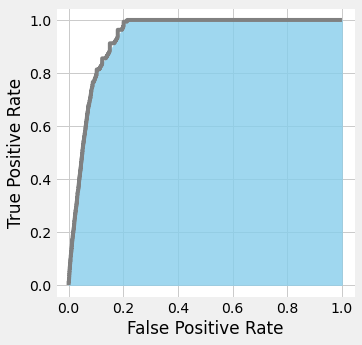

In [13]:
probas = rf.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [14]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', rf.score(x_test_transformed, x_test_target))

AUC score 	: 0.933181213267954
Model Score 	: 0.8848214285714285


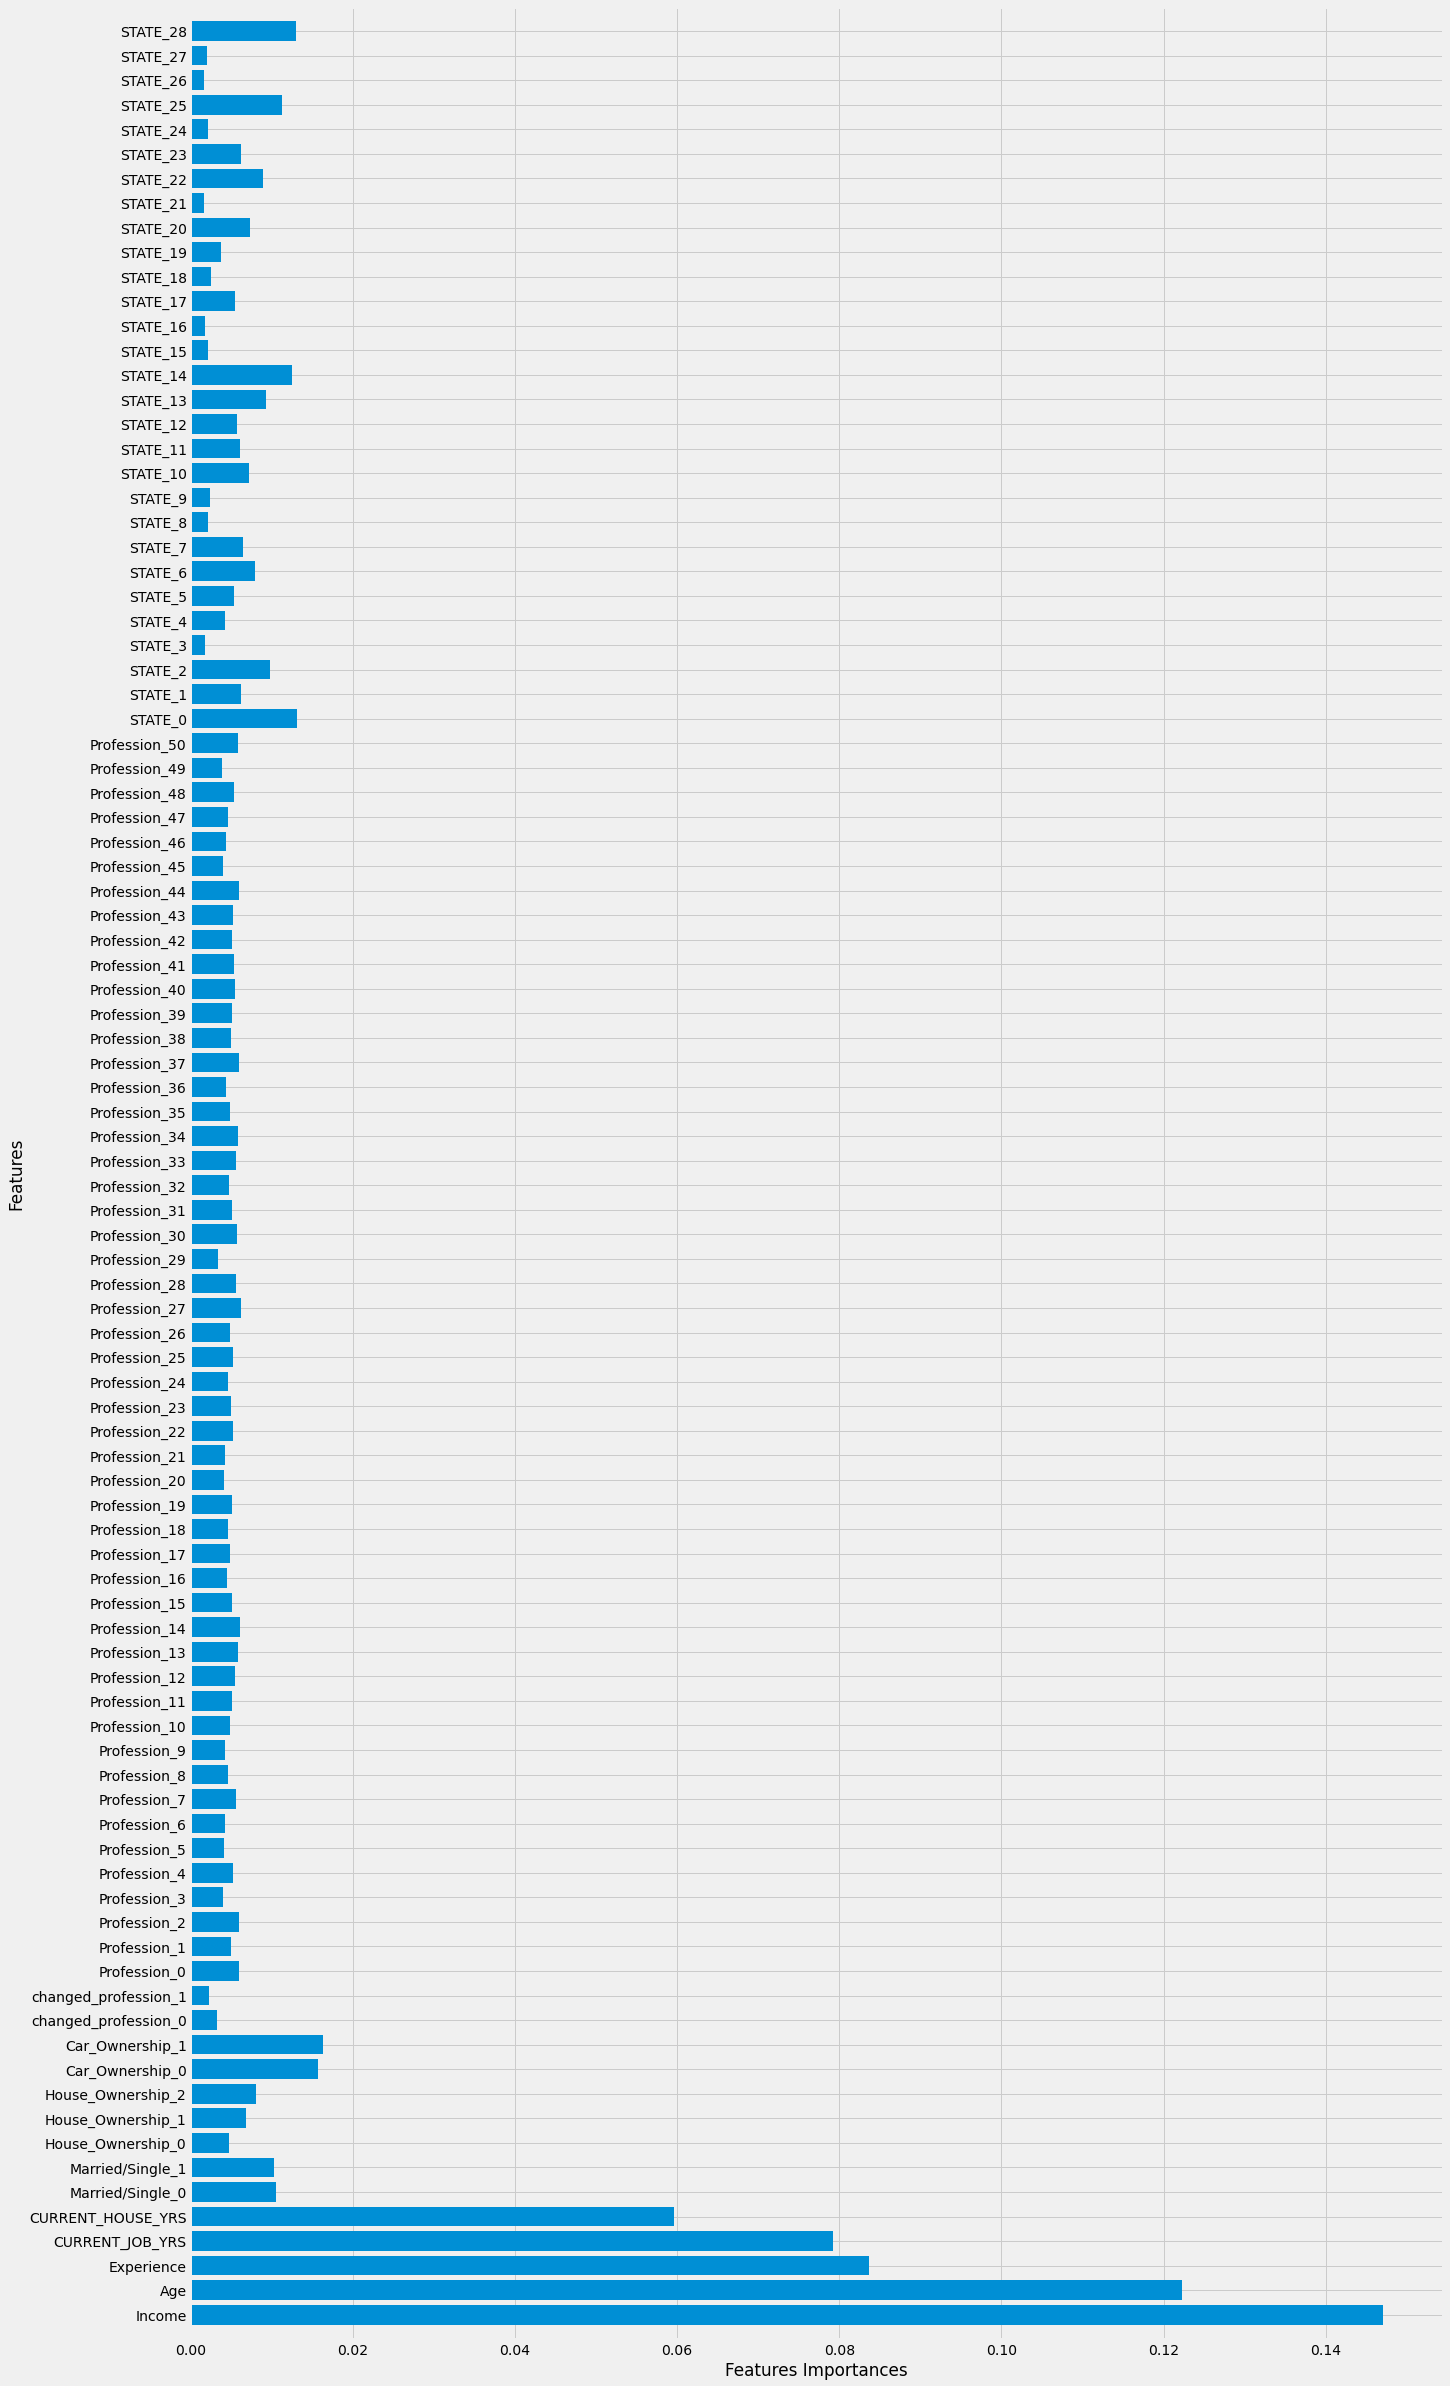

In [15]:
fn_feature_horizontal_graph(rf, x_train_transformed, x_train_data, numeric_features, categorical_features)

# 04. 딥러닝

In [63]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# import kerastuner as kt   
from tensorflow import keras 

from tensorflow.keras import datasets, utils
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization 

import IPython

In [ ]:
# x_train_target = x_train[['Risk_Flag']].copy()
# x_train_data = x_train.copy()

# x_test_target = x_test[['Risk_Flag']].copy()
# x_test_data = x_test.copy()

In [64]:
from sklearn import preprocessing

# Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(x_train_target).toarray()
test_label = enc.fit_transform(x_test_target).toarray()

print(train_label.shape) # 모양을 영어로?
print(test_label.shape) # 모양을 영어로?

(106047, 2)
(50400, 2)


In [65]:
model = models.Sequential()
#신경망 만들기
# model.add(layers.BatchNormalization()) # Use this line as if needed #오퍼피팅심하다싶으면 배치로
model.add(layers.Dense(input_dim=94, units=512, activation=None, kernel_initializer=initializers.he_uniform()))
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu')) 

model.add(layers.Dense(units=384, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.1)) 
 
model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [66]:
#묶어주는것 
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [ ]:
# x_train_transformed = preprocessor_pipe.transform(x_train_data)
# x_test_transformed = preprocessor_pipe.transform(x_test_data)

# x_train_tns = pd.DataFrame(x_train_transformed)
# x_test_tns = pd.DataFrame(x_test_transformed)

In [67]:
history = model.fit(x_train_transformed, train_label, batch_size=100, epochs=15, validation_split=0.1)

Epoch 1/15
955/955 [==============================] - 6s 6ms/step - loss: 0.5539 - categorical_accuracy: 0.7427 - val_loss: 1.2487 - val_categorical_accuracy: 0.0383
Epoch 2/15
955/955 [==============================] - 5s 6ms/step - loss: 0.4689 - categorical_accuracy: 0.7830 - val_loss: 0.9378 - val_categorical_accuracy: 0.4380
Epoch 3/15
955/955 [==============================] - 6s 6ms/step - loss: 0.3946 - categorical_accuracy: 0.8306 - val_loss: 0.9470 - val_categorical_accuracy: 0.5529
Epoch 4/15
955/955 [==============================] - 5s 6ms/step - loss: 0.3544 - categorical_accuracy: 0.8551 - val_loss: 1.0880 - val_categorical_accuracy: 0.5084
Epoch 5/15
955/955 [==============================] - 5s 6ms/step - loss: 0.3333 - categorical_accuracy: 0.8629 - val_loss: 1.1767 - val_categorical_accuracy: 0.4749
Epoch 6/15
955/955 [==============================] - 5s 6ms/step - loss: 0.3182 - categorical_accuracy: 0.8693 - val_loss: 0.6846 - val_categorical_accuracy: 0.7369
Epoc

In [68]:
# "Evaluate" the model on test data

result = model.evaluate(x_test_transformed, test_label) 
#모델 평가하는것(x,y)x데이터를 예측하고  y데이터를 만나게끔 함

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

1575/1575 [==============================] - 2s 1ms/step - loss: 0.2828 - categorical_accuracy: 0.8813
loss (cross-entropy) : 0.28279635310173035
test accuracy : 0.8812500238418579


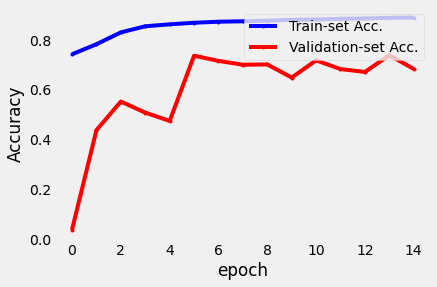

In [69]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc)) 

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

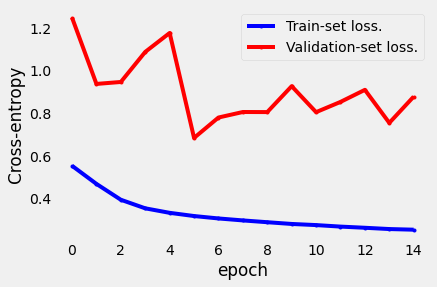

In [70]:
#graph(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# epoch 조정

In [73]:
history = model.fit(x_train_transformed, train_label, batch_size=100, epochs=6, validation_split=0.1)

Epoch 1/6
955/955 [==============================] - 5s 6ms/step - loss: 0.2484 - categorical_accuracy: 0.8922 - val_loss: 0.9838 - val_categorical_accuracy: 0.6628
Epoch 2/6
955/955 [==============================] - 5s 5ms/step - loss: 0.2441 - categorical_accuracy: 0.8939 - val_loss: 0.9328 - val_categorical_accuracy: 0.6488
Epoch 3/6
955/955 [==============================] - 5s 5ms/step - loss: 0.2397 - categorical_accuracy: 0.8963 - val_loss: 0.9875 - val_categorical_accuracy: 0.6398
Epoch 4/6
955/955 [==============================] - 5s 5ms/step - loss: 0.2365 - categorical_accuracy: 0.8974 - val_loss: 0.7771 - val_categorical_accuracy: 0.7102
Epoch 5/6
955/955 [==============================] - 5s 5ms/step - loss: 0.2328 - categorical_accuracy: 0.8978 - val_loss: 0.9205 - val_categorical_accuracy: 0.6930
Epoch 6/6
955/955 [==============================] - 5s 6ms/step - loss: 0.2288 - categorical_accuracy: 0.9003 - val_loss: 0.8183 - val_categorical_accuracy: 0.7313


In [78]:
# "Evaluate" the model on test data

result = model.evaluate(x_test_transformed, test_label) 
#모델 평가하는것(x,y)x데이터를 예측하고  y데이터를 만나게끔 함

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

1575/1575 [==============================] - 2s 1ms/step - loss: 0.2948 - categorical_accuracy: 0.8779
loss (cross-entropy) : 0.2948203980922699
test accuracy : 0.8778968453407288


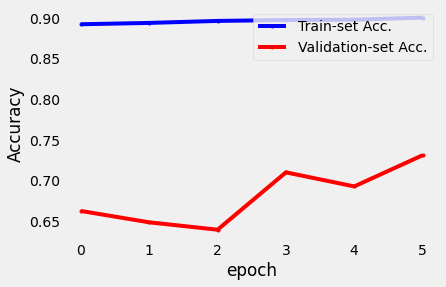

In [79]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc)) 

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

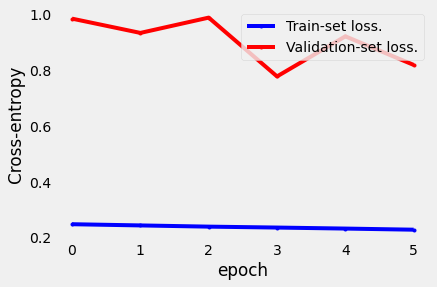

In [80]:
#graph(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# 케라스 튜너로 최적값 찾기

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
import kerastuner as kt

print(tf.__version__)
print(kt.__version__)

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers

In [ ]:
from sklearn import model_selection
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(94,))) #초기에 밀어넣는 열 넣어주면 됨 
        
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(2, activation='softmax')) # class 10 : 0~9

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['categorical_accuracy'])
    
    return model

In [ ]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_categorical_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'loan_default') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()

In [ ]:
# 4) Train the model

tuner.search(x_train_transformed, train_label, epochs=10, validation_data = (x_test_transformed, test_label)) 
# epochs == learning epoch for training a single model(epoch for each trial) 

In [ ]:
tuner.results_summary(num_trials=3)

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
#예측 결과 확인 - RandomForest

probas = rf.predict(x_test_transformed)

print("accuracy_score: " + str(accuracy_score(x_test_target, probas)))
print("precision_score: " + str(precision_score(x_test_target, probas)))
print("recall_score: " + str(recall_score(x_test_target, probas)))
print("f1_score: " + str(f1_score(x_test_target, probas)))

accuracy_score: 0.8848214285714285
precision_score: 0.5177890724269377
recall_score: 0.7962872496336102
f1_score: 0.627526467757459
